# Support Vector Machine - Regression - Linear

In this Jupyter notebook we're going to explore the linearSVM Regression using sklearn

In [1]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_boston
from sklearn.metrics import mean_absolute_error
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

In [2]:
boston = load_boston()
boston_df = pd.DataFrame(data=boston['data'], columns=boston['feature_names'])
boston_df['MEDV'] = boston['target']
X = boston_df[['RM', 'LSTAT', 'NOX']]
y = boston_df[['MEDV']]

## Load LR as our Baseline

In [3]:
from sklearn.model_selection import cross_val_score

lr = LinearRegression()
mae_lr = cross_val_score(lr, X, y, cv=5, scoring='neg_mean_absolute_error')
print("MAE: {:.2f}".format(np.abs(np.mean(mae_lr))*1000))

MAE: 4517.88


In [4]:
np.abs(np.mean(mae_lr))*1000

4517.878142239431

In [5]:
X.describe()

,RM,LSTAT,NOX
count,506.000000,506.000000,506.000000
mean,6.284634,12.653063,0.554695
std,0.702617,7.141062,0.115878
min,3.561000,1.730000,0.385000
25%,5.885500,6.950000,0.449000
50%,6.208500,11.360000,0.538000
75%,6.623500,16.955000,0.624000
max,8.780000,37.970000,0.871000


### SVM standardisation

Use PowerTransformer 

...to make data more like standard normal gaussian. (mean=0, std=1).
This will be explained in more detail in the EDA section

/Users/heather/anaconda3/envs/udemyml/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


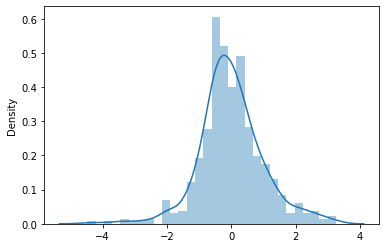

In [6]:
from sklearn.preprocessing import PowerTransformer
import seaborn as sns

X_transformed = PowerTransformer(method="yeo-johnson").fit_transform(X)
_ = sns.distplot(X_transformed[:,0])

In [7]:
np.mean(X_transformed, axis=0)

array([ 1.33051234e-15, -3.08931624e-16,  1.74125097e-15])

In [8]:
np.std(X_transformed, axis=0)

array([1., 1., 1.])

/Users/heather/anaconda3/envs/udemyml/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


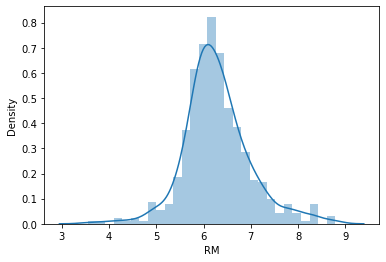

In [9]:
_ = sns.distplot(X['RM'])

/Users/heather/anaconda3/envs/udemyml/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


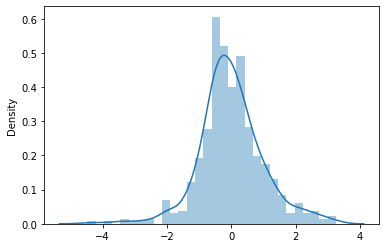

In [10]:
_ = sns.distplot(X_transformed[:,0])

## SVM Regression with Linear

Define a pipeline to ensure that data from test set doesn't leak into training set, when using cross_val_score

In [11]:
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVR

#svr = SVR(kernel='linear')
transformer = PowerTransformer(method="yeo-johnson")
svr = make_pipeline(transformer, SVR(kernel='linear'))
mae_lin = cross_val_score(svr, X, y.values.ravel(), cv=5, scoring='neg_mean_absolute_error')
print("MAE : {:.2f}".format(np.abs(np.mean(mae_lin))*1000))

MAE : 4400.05


## SVM with margin (epsilon)

In [12]:
svr = make_pipeline(transformer, SVR(kernel='linear', epsilon=2))
mae_lin = cross_val_score(svr, X, y.values.ravel(), cv=5, scoring='neg_mean_absolute_error')
print("MAE : {:.2f}".format(np.abs(np.mean(mae_lin))*1000))

MAE : 4321.80


## SVM with margin & slack (C)

In [13]:
svr = make_pipeline(transformer, SVR(kernel='linear', epsilon=2, C=0.5))
mae_lin = cross_val_score(svr, X, y.values.ravel(), cv=5, scoring='neg_mean_absolute_error')
print("MAE : {:.2f}".format(np.abs(np.mean(mae_lin))*1000))

MAE : 4320.33


## Grid Search cross validation

In [14]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

pipeline = Pipeline([("transform", transformer), 
                     ("model", SVR(kernel='linear'))])
grid = {
    'model__epsilon' : [0.5, 1, 1.5, 1.75, 2.0, 2.5, 2.75, 2.8, 2.9, 3.0, 3.3, 3.5, 4.0],
    'model__C': np.linspace(0.1, 10, 20)
}

grid_svr = GridSearchCV(pipeline, grid, scoring='neg_mean_absolute_error', cv=5)

In [15]:
_ = grid_svr.fit(X, y.values.ravel())

In [16]:
grid_svr.best_params_

{'model__C': 0.6210526315789474, 'model__epsilon': 2.9}

In [17]:
print("epsilon:", grid_svr.best_params_['model__epsilon'])
print("C:", grid_svr.best_params_['model__C'])

epsilon: 2.9
C: 0.6210526315789474


In [18]:
pipeline = make_pipeline(transformer, 
                    SVR(kernel='linear', 
                        epsilon=grid_svr.best_params_['model__epsilon'], 
                        C=grid_svr.best_params_['model__C']))

mae_lin = cross_val_score(pipeline, X, y.values.ravel(), cv=5, scoring='neg_mean_absolute_error')
print("MAE : {:.2f}".format(np.abs(np.mean(mae_lin))*1000))

MAE : 4247.91
